In [18]:
import boto3
from botocore.exceptions import ClientError


bucket = 'sleep-quality-forecast-bucket'
key = 'processed/sleep_data_clean.csv'
s3 = boto3.client('s3')

In [19]:
import pandas as pd
from io import StringIO

# Load cleaned data
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(obj['Body'])
df.head()

,SESSION_DATE,SLEEP_SCORE,USAGE_HOURS,AHI,MASK_SESSION_COUNT,LEAK_50_PERCENTILE,LEAK_70_PERCENTILE,LEAK_95_PERCENTILE,DAY_OF_WEEK
0,2023-05-11,96,9.95,0.1,5,0.0,0.0,0.0,Thursday
1,2023-05-12,96,10.73,0.5,5,0.0,0.0,0.0,Friday
2,2023-05-13,98,10.22,0.3,4,0.0,0.0,0.0,Saturday
3,2023-05-14,100,9.97,0.3,2,0.0,0.0,0.0,Sunday
4,2023-05-15,95,8.80,0.6,6,0.0,0.0,0.0,Monday


In [22]:
X = df[['USAGE_HOURS', 'AHI', 'MASK_SESSION_COUNT',
        'LEAK_50_PERCENTILE', 'LEAK_70_PERCENTILE', 'LEAK_95_PERCENTILE']]
y = df['SLEEP_SCORE']


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)  # train model
    y_pred = model.predict(X_test)  # predict on unseen data
    results.append({
        "Model": name,
        "R2": r2_score(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
results_df


/opt/conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,R2,RMSE
1,Random Forest,0.898045,4.401411
2,XGBoost,0.822221,7.674775
3,Neural Network,0.365848,27.376490
0,Linear Regression,0.318567,29.417613


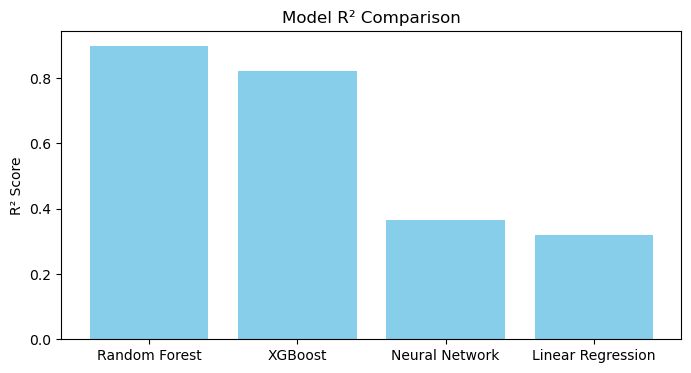

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(results_df['Model'], results_df['R2'], color='skyblue')
plt.title('Model R² Comparison')
plt.ylabel('R² Score')
plt.show()

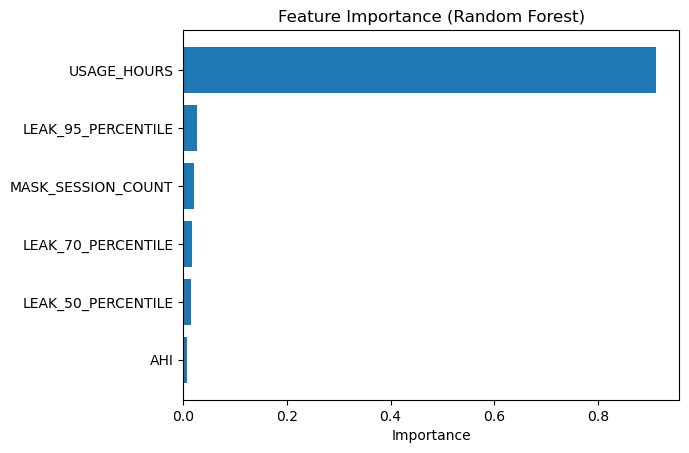

In [26]:
import numpy as np

rf = models["Random Forest"]
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.barh(X.columns[indices], importances[indices])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

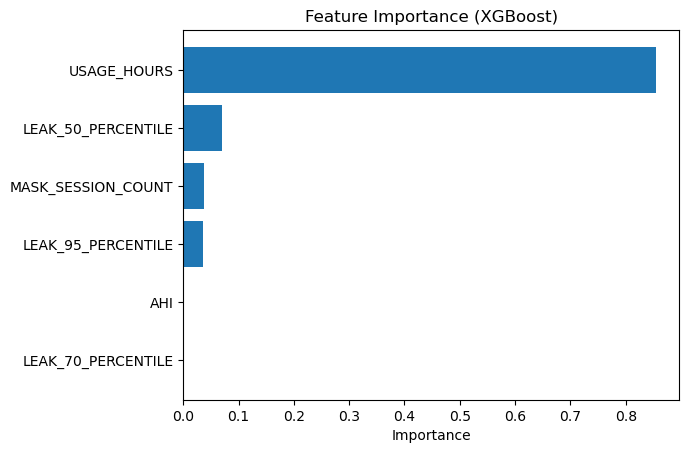

In [27]:
import numpy as np

rf = models["XGBoost"]
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.barh(X.columns[indices], importances[indices])
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.show()